In [1]:
# parameters to vary: 
#   ch4 base
#   haloe
#   aoa
#   yield
#   pletzer


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from openairclim.calc_swv import get_volume_matrix, get_griddata, construct_myhre_1m_df
from ambiance import Atmosphere
import pandas as pd

M_h2o = 18.01528 * 10**-3  # kg/mol
M_air = 28.97 * 10**-3  # kg/mol



In [22]:
def calc_swv_mass_conc(delta_ch4, alpha_new = None, aoa_new=None, factor_new=None, ch4entry_new = 1.778, haloe_new = None):
    """
    Calculates the SWV concentration and mass based on the oxidation of CH4. It is based on the tropospheric CH4 change, the fractional release factor, and the Age-of-Air.
    Based on the papers of Austin 2007, Hegglin 2014 and Harmsen 2026 #TODO make the citations correct

    Args:
        delta_ch4 (list): List of yearly changes in CH4 concentration due to an emission.
        alpha (np.ndarray): The fractional release factor of CH4, based on altitude and latitude.
        AoA: (np.ndarray): The age-of-air based on altitude and latitude rounded to the nearest integer year.

    Returns:
        delta_mass_swv (list): A list of the total change in SWV mass in Tg due to CH4 oxidation for each year corresponding to delta_ch4.
        delta_conc_swv (list): A list with the average stratospheric concentration change of SWV in ppbv due to CH4 oxidation for each year corresponding to delta_ch4.
    """
    # initialize
    delta_mass_swv = np.ones(len(delta_ch4))
    delta_conc_swv = np.ones(len(delta_ch4))

    # define constants
    delta_h = 100.0  # height increment in meters
    delta_deg = 1.0  # latitude increment
    heights = np.arange(0, 60000 + delta_h, delta_h)  # 0 to 60 km

    latitudes = np.arange(
        -85, 85, delta_deg
    )  # -85° to 85° #TODO verify these numbers, justify the values,
    # TODO this gives sometimes a non 0 in the first year, why?
    # TODO probably due to the extrpolating of the grid introducing tropospheric values

    volume = get_volume_matrix(heights, latitudes, delta_h, delta_deg)
    density = Atmosphere(heights).density
    mass_mat = volume * density[:, np.newaxis]  # kg
    alpha, AoA = get_alpha_AOA(heights, latitudes, plot_data=False, tp_value = ch4entry_new, haloe_new = haloe_new)
    if alpha_new != None:
        alpha = alpha_new*alpha # alpha changes as a fraction
    if aoa_new != None:
        aoa = pd.DataFrame(0.3 + 15.2 * alpha - 21.2 * alpha**2 + 10.4 * alpha**3)
        AoA = (aoa + aoa_new).clip(lower=0).round(0) # aoa changes with a fixed amount
        
    for t in range(len(delta_ch4)):
        # get swv distribution
        multiplier_map = {
            1: delta_ch4[t - 1] if t - 1 >= 0 else 0.0,
            2: delta_ch4[t - 2] if t - 2 >= 0 else 0.0,
            3: delta_ch4[t - 3] if t - 3 >= 0 else 0.0,
            4: delta_ch4[t - 4] if t - 4 >= 0 else 0.0,
            5: delta_ch4[t - 5] if t - 5 >= 0 else 0.0,
        }
        df_ch4_lagged = AoA.replace(multiplier_map)
        if factor_new == None:
            swv = 2 * alpha * df_ch4_lagged  # ppbv
        else:
            swv = factor_new *alpha * df_ch4_lagged

        # calculate average concentration
        number_density = Atmosphere(heights).number_density
        swv_parts_mat = volume * number_density[:, np.newaxis] * swv * 1e-9
        tot_parts = np.nansum(
            (
                volume
                * np.where(np.isnan(swv_parts_mat), np.nan, 1)
                * number_density[:, np.newaxis]
            )
        )  # to make sure only stratospheric volume is taken
        average_conc = np.nansum(swv_parts_mat) / tot_parts * 1e9  # ppbv

        # calculate total swv mass
        SWV_mass_mat = swv * 10**-9 * M_h2o / M_air * mass_mat  # kg
        swv_mass = np.nansum(SWV_mass_mat) / 1e9  # Tg
        # print(swv_mass)

        # store data
        delta_mass_swv[t] = swv_mass  # Tg
        delta_conc_swv[t] = average_conc  # ppbv
    final_swv_distribution = swv
    return delta_mass_swv, delta_conc_swv, final_swv_distribution


def calc_swv_rf(total_swv_mass, rf_new=None):  # mass in Tg # TODO note that i adapted teh code to handle lists
    """
    Function to calculate the RF due to a certain SWV perturbation mass. Based on Pletzer (2024) #TODO fix citation

    Args:
        total_swv_mass (dict): A dict with the key "SWV" with an array with the SWV mass in Tg for corresponding year
    Raises:
        TypeError: if total_SWV_mass is not a dict
        ValueError: if the total mass is out of range of the plot of Pletzer (2024)

    Returns:
        rf_swv_dict (dict): A dict that contains the forcing due to SWV at that time
    """
    # based on the formula of Pletzer 2024
    # if not isinstance(total_swv_mass, dict):
    #     raise TypeError("total SWV mass must be a float or integer")

    rf_swv_list = []
    a = -0.00088
    b = 0.47373
    c = -0.74676
    for value in total_swv_mass:
        negative = False
        if value < 0:
            negative = True
            value = abs(value)
        if value > 160:
            raise ValueError("Total SWV mass out of range of Pletzer plot")
        if value < 1.6:
            # Make sure that values smaller than 1.6 Tg cause 0 impact instead of impact with the wrong sign
            rf_value = 0
        else:
            rf_value = (
                a * value**2 + b * value + c
            ) / 1000  # to make it W/m2 from mW/m2
        if negative == True:
            rf_value = rf_value * -1
        rf_swv_list.append(rf_value)
    rf_swv_array = np.array(rf_swv_list)
    #SENSITIVITY:
    if rf_new != None:
        rf_swv_array = rf_swv_array*rf_new
        
    rf_swv_dict = {"SWV": rf_swv_array}
    return rf_swv_array


def get_alpha_AOA(heights, latitudes, plot_data=False, tp_value = 1.778, haloe_new = None):
    """
    Function to construct the fractional release factor for CH4 (alpha) and the age-of air rounded to whole years.

    Returns:
        alpha (np.ndarray): A matrix of fractional release factors for different altitude and latitude levels.
        AoA (np.ndarray): A matrix of the rounded age of air for different altitude and latitude levels.
    """

    # tp_value = 1.778  # TODO evaluate this number
    df = construct_myhre_1m_df(tropopause_value=tp_value, cp_lat=87, cp_a=80)

    if haloe_new == None:
        grid = get_griddata(df, heights, latitudes, plot_data=False)

    else:
        grid = get_griddata(df, heights, latitudes, plot_data=False)*haloe_new

    ### This grid will resemble the HAlOE CH4 concentrtion (ppmv)data of myhre fig 1

    ch4_e = tp_value  # ppmv # TODO
    alpha = (ch4_e - grid) / ch4_e

    aoa = 0.3 + 15.2 * alpha - 21.2 * alpha**2 + 10.4 * alpha**3

    AoA = pd.DataFrame(aoa.round(0))
    return alpha, AoA


In [31]:
# alpha_dict = {'input':[0.9, 0.95, 1, 1.05, 1.1], 'output':[]}
haloe_dict = {'input':[0.85, 1, 1.15], 'output_mass':[], 'output_rf':[]}
ch4entry_dict = {'input':[1.729, 1.75376, 1.778], 'output_mass':[], 'output_rf':[]}
aoa_dict = {'input':[-0.3, 0, 0.3], 'output_mass':[], 'output_rf':[]}
factor_dict = {'input':[1.4, 2, 2.2], 'output_mass':[], 'output_rf':[]}
rf_dict = {'input':[0.9, 1, 1.1], 'output_mass':[], 'output_rf':[]}

for haloe_new in haloe_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], haloe_new=haloe_new)
    rf = calc_swv_rf(m)
    print('haloe:', haloe_new, 'mass:', m[-1], 'rf:', rf[-1])
    haloe_dict['output_mass'].append(m.round(2))
    haloe_dict['output_rf'].append(rf.round(7))
for ch4entry_new in ch4entry_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], ch4entry_new=ch4entry_new)
    rf = calc_swv_rf(m)
    print('ch4entry:', ch4entry_new, 'mass:', m[-1], 'rf:', rf[-1])
    ch4entry_dict['output_mass'].append(m.round(2))
    ch4entry_dict['output_rf'].append(rf.round(7))
for aoa_new in aoa_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], aoa_new=aoa_new)
    rf = calc_swv_rf(m)
    print('aoa:', aoa_new, 'mass:', m[-1], 'rf:', rf[-1])
    aoa_dict['output_mass'].append(m.round(2))
    aoa_dict['output_rf'].append(rf.round(7))
for factor_new in factor_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100], factor_new=factor_new)
    rf = calc_swv_rf(m)
    print('factor:', factor_new, 'mass:', m[-1], 'rf:', rf[-1])
    factor_dict['output_mass'].append(m.round(2))
    factor_dict['output_rf'].append(rf.round(7))
for rf_new in rf_dict['input']:
    m, c, d = calc_swv_mass_conc([100,100,100,100,100,100,100])
    rf = calc_swv_rf(m, rf_new=rf_new)
    print('rf:', rf_new, 'mass:', m[-1], 'rf:', rf[-1])
    rf_dict['output_mass'].append(m.round(2))
    rf_dict['output_rf'].append(rf.round(7))

haloe: 0.85 mass: 50.558384774189314 rf: 0.020954851380618724
haloe: 1 mass: 23.29461065233141 rf: 0.009811073685138493
haloe: 1.15 mass: 12.985892884369003 rf: 0.005256649631788338
ch4entry: 1.729 mass: 21.073513955302698 rf: 0.008845593934472129
ch4entry: 1.75376 mass: 22.214118974770898 rf: 0.009342483549911976
ch4entry: 1.778 mass: 23.29461065233141 rf: 0.009811073685138493
aoa: -0.3 mass: 23.013556736045757 rf: 0.009689383294160941
aoa: 0 mass: 23.29461065233141 rf: 0.009811073685138493
aoa: 0.3 mass: 23.347876138185153 rf: 0.009834120841198103
factor: 1.4 mass: 16.306227456631984 rf: 0.006744003245626941
factor: 2 mass: 23.29461065233141 rf: 0.009811073685138493
factor: 2.2 mass: 25.624071717564547 rf: 0.010814329609541387
rf: 0.9 mass: 23.29461065233141 rf: 0.008829966316624643
rf: 1 mass: 23.29461065233141 rf: 0.009811073685138493
rf: 1.1 mass: 23.29461065233141 rf: 0.010792181053652343


In [30]:
# SENSITIVITY FROM SLIDE 23 PPT 4 

#S+ = (X+-X)/(dP/P) and with +=-
# # for alpha:
# X_min = alpha_dict['output'][0][-1]
# X = alpha_dict['output'][2][-1]
# X_plus = alpha_dict['output'][-1][-1]
# dP_over_P = 0.1
# S_min = (X_min-X)/dP_over_P
# S_plus = (X_plus-X)/dP_over_P
# print('alpha: ',S_min,S_plus)

#for haloe:
X_min = haloe_dict['output'][0][-1]
X = haloe_dict['output'][1][-1]
X_plus = haloe_dict['output'][2][-1]
dP_over_P = 0.15
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('haloe: ',S_min,S_plus)

#for ch4entry:
X_min = ch4entry_dict['output'][0][-1]
X = ch4entry_dict['output'][1][-1]
X_plus = ch4entry_dict['output'][2][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('ch4entry: ',S_min,S_plus)

#for aoa:
X_min = aoa_dict['output'][0][-1]
X = aoa_dict['output'][2][-1]
X_plus = aoa_dict['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('aoa: ',S_min,S_plus)

#for aoa:
X_min = aoa_dict['output'][0][-1]
X = aoa_dict['output'][2][-1]
X_plus = aoa_dict['output'][-1][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('aoa: ',S_min,S_plus)

# for factor:
X_min = factor_dict['output'][0][-1]
X = factor_dict['output'][1][-1]
X_plus = factor_dict['output'][2][-1]
dP_over_P = 0.1
S_min = (X_min-X)/dP_over_P
S_plus = (X_plus-X)/dP_over_P
print('factor: ',S_min,S_plus)


haloe:  186.66666666666669 -66.66666666666667
ch4entry:  -10.0 10.0
aoa:  0.0 0.0
aoa:  0.0 0.0
factor:  -69.88383195699427 23.294610652331365


In [33]:
data_dict = {'haloe':haloe_dict,
             'ch4entry':ch4entry_dict,
             'aoa':aoa_dict,
             'factor':factor_dict,
             'rf':rf_dict}


0 haloe
1 ch4entry
2 aoa
3 factor
4 rf


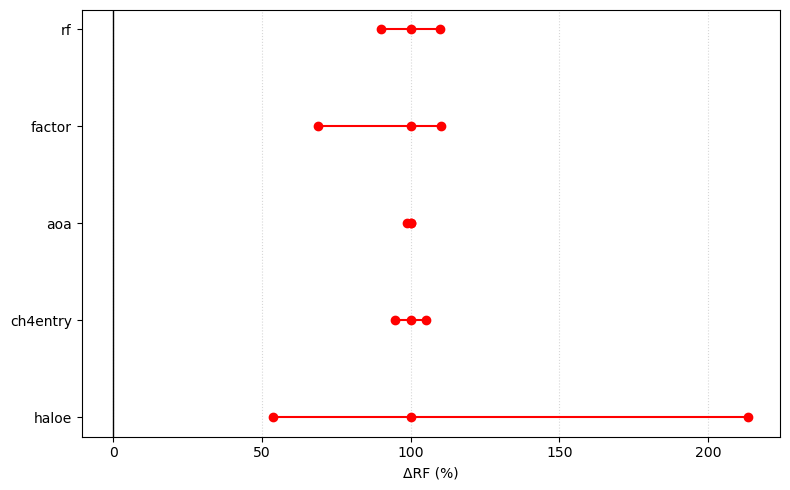

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))

for i, values in enumerate(data_dict):
    print(i, values)
    vmin = data_dict[values]['output_rf'][0][-1]/data_dict[values]['output_rf'][1][-1]*100
    vmean = data_dict[values]['output_rf'][1][-1]/data_dict[values]['output_rf'][1][-1]*100
    vmax = data_dict[values]['output_rf'][2][-1]/data_dict[values]['output_rf'][1][-1]*100

    # Horizontal line (range)
    ax.plot([vmin, vmean, vmax], [i, i, i], '-', marker='o', color='red')

# Formatting
ax.set_yticks(range(len(data_dict)))
ax.set_yticklabels(data_dict.keys())
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel("ΔRF (%)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

In [35]:
haloe_dict

{'input': [0.85, 1, 1.15],
 'output_mass': [array([ 0.  ,  0.  , 16.07, 33.73, 50.56, 50.56, 50.56]),
  array([ 0.  ,  1.82,  6.79, 14.3 , 23.29, 23.29, 23.29]),
  array([ 0.31,  1.27,  3.52,  7.34, 12.99, 12.99, 12.99])],
 'output_rf': [array([0.       , 0.       , 0.0066392, 0.01423  , 0.0209549, 0.0209549,
         0.0209549]),
  array([0.       , 0.0001117, 0.0024312, 0.0058481, 0.0098111, 0.0098111,
         0.0098111]),
  array([0.       , 0.       , 0.0009087, 0.002682 , 0.0052566, 0.0052566,
         0.0052566])]}